# Comparison of Neural networks methods with other benchmark
We compare NN method with benchmark for convex hull (LCH) method introduced in "Unraveling intermittent features in single-particle trajectories by a local convex hull method"
https://www.researchgate.net/publication/319235599_Unraveling_intermittent_features_in_single-particle_trajectories_by_a_local_convex_hull_method

Notes:
1. In LCH method the recognition score is a function of τ (time window for convex hull) and it is not a monotonous function, since there is an optimal value of window size given T (total lengnth of trajectory). 
2. Recognition score R is calculated of the diameter-based discriminator Sd(n) and area based discriminator Sa(n)
3. LCH method is quite sensitive to noise and for that one needs to use higher τ (time window for convex hull)
4. The local convex hull captures changes in the mutual arrangment of points, in a somewhat similar way as our eyes do. The diameter and the volume are the basic geometric characteristics of the LCH that reflect, respectively, the overall size and anisotropy of points

In [1]:
import numpy as np
import torch
import os
import sys
sys.path.append('../')

from src.features import Q_measure, dist_distribution, convex_hull
from src.andi_tools import Andi_to_xy
from src.training import FeedForward

%load_ext autoreload
%autoreload 2

# Generate data
Idea is to generate and load data with different types for which results on Q measure and convex hull are known and studied:
1. two planar Brownian motions with distinct diffusion coefficients D1 and D2 (change in diffusivity);
2. two planar fractional Brownian motions with distinct Hurst exponents H1 and H2 (change in auto- correlations).

Generation using andi tools ['attm', 'ctrw', 'fbm', 'lw', 'sbm']: 
1. For α = 1 the noise is uncorrelated, hence the FBM converges to usual Brownian motion. 
2. Fractional Brownian motion (FBM) arises from the Langevin equation dx(t)dt = ξfGn(t), where ξfGn is a fractional Gaussian noise. the Hurst exponent is used as a measure of the long-term memory of a time series

### Problem
With Andi I cannot really generate Brownian motion with different diffusion coefficients (see below), so I can use standard Euler Maryama scheme for generating them. 

In [10]:
import andi

AD = andi.andi_datasets()
AD.avail_models_name

T_len = 500
N_tot = 2000
N_test = 200


#dataset_bm = AD.create_dataset(T = T_len, N = N_tot, exponents = [1], models = [ 2])
dataset_fbm1 = AD.create_dataset(T = T_len, N = N_test, exponents = [0.4], models = [ 2])
dataset_fbm1 = AD.create_dataset(T = T_len, N = N_test, exponents = [0.9], models = [ 2])

#input_data = dataset[:,2:]
#input_data = torch.FloatTensor(input_data.reshape((3*N_tot,-1,1)))[:,None,:,:]
#labels = torch.Tensor(dataset[:,0].astype(int))
#labels = labels.type(torch.LongTensor)

#idx = np.random.permutation(labels.shape[0])

#input_data = input_data[idx,:,:,:]
#labels = labels[idx]

#input_data_test = dataset_test[:,2:]
#labels_test = torch.Tensor(dataset_test[:,0].astype(int))
#labels_test = labels_test.type(torch.LongTensor)
#input_data_test = torch.FloatTensor(input_data_test.reshape((3*N_test,-1,1)))[:,None,:,:]

# Generate Brownian motion
We can use a numerical technique to approximate the solution. One of the most straightforward approximations is the Euler-Maruyama Method for SDE
wi+1=wi−μwiΔti+σΔWi

Text(0.5, 1.0, 'Geometric Brownian Motion, Dif.coef.=2')

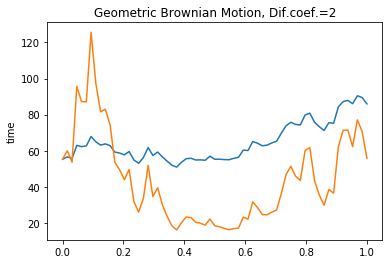

In [8]:
import numpy as np
import matplotlib.pyplot as plt

seed = 5       
N  = 2.**6     # increments

def Brownian(seed, N):
    
    np.random.seed(seed)                         
    dt = 1./N                                    # time step
    b = np.random.normal(0., 1., int(N))*np.sqrt(dt)  # brownian increments
    W = np.cumsum(b)                             # brownian path
    return W, b


# brownian increments
b = Brownian(seed, N)[1]

# brownian motion
W = Brownian(seed, N)[0]
W = np.insert(W, 0, 0.)   

# GBM Exact Solution

# Parameters
#
# So:     initial stock price
# mu:     returns (drift coefficient)
# sigma:  volatility (diffusion coefficient)
# W:      brownian motion
# T:      time period
# N:      number of increments

def GBM(So, mu, sigma, W, T, N):    
    t = np.linspace(0.,1.,N+1)
    S = []
    S.append(So)
    for i in range(1,int(N+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        diffusion = sigma * W[i-1]
        S_temp = So*np.exp(drift + diffusion)
        S.append(S_temp)
    return S, t

So = 55.25
mu = 0.15
sigma = 0.4
W = Brownian(seed, N)[0]
T = 1.
N = 2.**6

soln = GBM(So, mu, sigma, W, T, N)[0]    # Exact solution
t = GBM(So, mu, sigma, W, T, N)[1]       # time increments for  plotting

plt.plot(t, soln)
plt.ylabel('Random walk position') # could be also Stock Price, $
plt.ylabel('time') # could be also Stock Price, $
plt.title('Geometric Brownian Motion, Dif.coef.='+str(sigma))

So = 55.25
mu = 0.15
sigma = 2
W = Brownian(seed, N)[0]
T = 1.
N = 2.**6

soln = GBM(So, mu, sigma, W, T, N)[0]    # Exact solution
t = GBM(So, mu, sigma, W, T, N)[1]       # time increments for  plotting

plt.plot(t, soln)
plt.ylabel('Random walk position in 1D') # could be also in 2D
plt.ylabel('time') # could be also Stock Price, $
plt.title('Geometric Brownian Motion, Dif.coef.='+str(sigma))




# Load data 
We load data, which we will be testing the method for. 

In [2]:

import pandas as pd
import csv

# load data on trajectories, it is very heavy 
trajectories_experiment = pd.read_csv('../data/data_sample_trajectory_2d.csv') #, labels = Andi_to_xy("data/test_2d.csv","data/label_2d.csv")


# Training on labelled data
We are using data from Andi challenge. 


In [3]:
trajectories, labels = Andi_to_xy("data/test_2d.csv","data/label_2d.csv")# ("data/test_2d_12.csv","data/label_2d_12.csv")
labels = torch.FloatTensor(labels)
labels = torch.max(labels, 1)[1]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 78 and the array at index 1 has size 79

In [3]:
features =[Q_measure(trajectories, 2),
            Q_measure(trajectories, 4),
            Q_measure(trajectories, 6),
          dist_distribution(trajectories)]
feature_sizes = [f.shape[1] for f in features]
features = [torch.FloatTensor(f) for f in features]


In [10]:
model = FeedForward(feature_sizes)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # learning rate default is 0.01 
#Remy: I would keep Adam for most applications, it's super robust in general, you can try to lower the learning rate since, by default its 10**-3 

In [11]:
model.train()
epoch = 1000
for epoch in range(epoch):    
    optimizer.zero_grad()    # Forward pass
    y_pred = model(features)    # Compute Loss
    loss = criterion(y_pred.squeeze(), labels)
   
    #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))    # Backward pass
    loss.backward()
    optimizer.step()

In [12]:
after_train = criterion(y_pred,labels)

In [15]:
prediction = torch.max(y_pred, 1)[1]

In [16]:
nonzero = np.count_nonzero(np.argmax(y_pred.detach().numpy(),axis=1)-labels.detach().numpy())
tot = len(np.argmax(y_pred.detach().numpy(),axis=1)-labels.detach().numpy())

In [17]:
(tot-nonzero)/tot

# change the optimiser of the model and its parameters above 
# optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
#0.456 for lr=0.01
#0.33 for lr=0.001

0.33